<a href="https://colab.research.google.com/github/Alenushka2013/Khpi_master_studing/blob/main/ML_lab1_1_Olena_Kirieva_MK_H125.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression Week 1: Simple Linear Regression

In this notebook we will use data on house sales in King County to predict house prices using simple (one input) linear regression. You will:
* Use pandas and numpy functions to compute important summary statistics
* Write a function to compute the Simple Linear Regression weights using the closed form solution
* Write a function to make predictions of the output given the input feature
* Turn the regression around to predict the input given the output
* Compare two different models for predicting house prices

In this notebook you will be provided with some already complete code as well as some code that you should complete yourself in order to answer quiz questions. The code we provide to complte is optional and is there to assist you with solving the problems but feel free to ignore the helper code and write your own.

# Fire up libs

In [1]:
import pandas as pd
from sklearn import model_selection
import numpy as np

# Load house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

Джерело даних https://www.kaggle.com/datasets/harlfoxem/housesalesprediction

| Назва колонки | Пояснення |
|:----------------|:-----------|
| **0. `id`** | Унікальний ідентифікатор кожного будинку (номер запису). |
| **1. `date`** | Дата продажу (у форматі `YYYYMMDDT000000`, наприклад `20141013T000000`). |
| **2. `price`** | Ціна продажу будинку (у доларах США) — цільова змінна для прогнозування. |
| **3. `bedrooms`** | Кількість спалень. |
| **4. `bathrooms`** | Кількість ванних кімнат (значення може бути дробовим, наприклад 1.5 — одна повна й одна половинна ванна). |
| **5. `sqft_living`** | Житлова площа будинку в квадратних футах. |
| **6. `sqft_lot`** | Площа земельної ділянки, на якій розташований будинок. |
| **7. `floors`** | Кількість поверхів. |
| **8. `waterfront`** | Ознака, чи має будинок вихід до води (0 — ні, 1 — так). |
| **9. `view`** | Оцінка виду з будинку (0–4, де 4 — найкращий вигляд). |
| **10. `condition`** | Загальний стан будинку (1–5, де 5 — найкращий стан). |
| **11. `grade`** | Клас будинку за шкалою будівельної оцінки (1–13, вищий бал — якісніше виконання). |
| **12. `sqft_above`** | Площа будинку над рівнем землі (без підвалу). |
| **13. `sqft_basement`** | Площа підвалу. |
| **14. `yr_built`** | Рік побудови. |
| **15. `yr_renovated`** | Рік останнього ремонту (0 — якщо ремонту не було). |
| **16. `zipcode`** | Поштовий індекс району, де розташований будинок. |
| **17. `lat`** | Географічна широта (latitude). |
| **18. `long`** | Географічна довгота (longitude). |
| **19. `sqft_living15`** | Середня житлова площа 15 найближчих сусідів. |
| **20. `sqft_lot15`** | Середня площа ділянки 15 найближчих сусідів. |


In [2]:
sales = pd.read_csv('kc_house_data.csv')

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def quick_eda(df, ncols=3, figsize=(15, 10)):
    """
    Швидка візуалізація числових колонок:
    - гістограми розподілу
    - boxplot (для пошуку викидів)
    - теплокарта кореляцій
    """
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    n = len(num_cols)

    # --- 1. Гістограми ---
    fig, axes = plt.subplots(nrows=(n // ncols) + 1, ncols=ncols, figsize=figsize)
    axes = axes.flatten()
    for i, col in enumerate(num_cols):
        sns.histplot(df[col].dropna(), kde=True, ax=axes[i])
        axes[i].set_title(f"Histogram: {col}")
    plt.tight_layout()
    plt.show()

    # --- 2. Boxplots ---
    fig, axes = plt.subplots(nrows=(n // ncols) + 1, ncols=ncols, figsize=figsize)
    axes = axes.flatten()
    for i, col in enumerate(num_cols):
        sns.boxplot(x=df[col], ax=axes[i])
        axes[i].set_title(f"Boxplot: {col}")
    plt.tight_layout()
    plt.show()


def target_relations(df, target, ncols=3, figsize=(18, 12)):
    """
    Будує графіки залежності цільової змінної від числових ознак:
    - scatterplot (розсіювання)
    - boxplot (для дискретних змінних із невеликою кількістю унікальних значень)
    """
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop(target)
    n = len(num_cols)

    fig, axes = plt.subplots((n // ncols) + 1, ncols=ncols, figsize=figsize)
    axes = axes.flatten()

    for i, col in enumerate(num_cols):
        # якщо змінна має мало унікальних значень — boxplot, інакше scatterplot
        if df[col].nunique() < 10:
            sns.boxplot(x=col, y=target, data=df, ax=axes[i])
        else:
            sns.scatterplot(x=col, y=target, data=df, alpha=0.5, ax=axes[i])
        axes[i].set_title(f"{target} vs {col}")

    # приховати порожні subplot-и
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

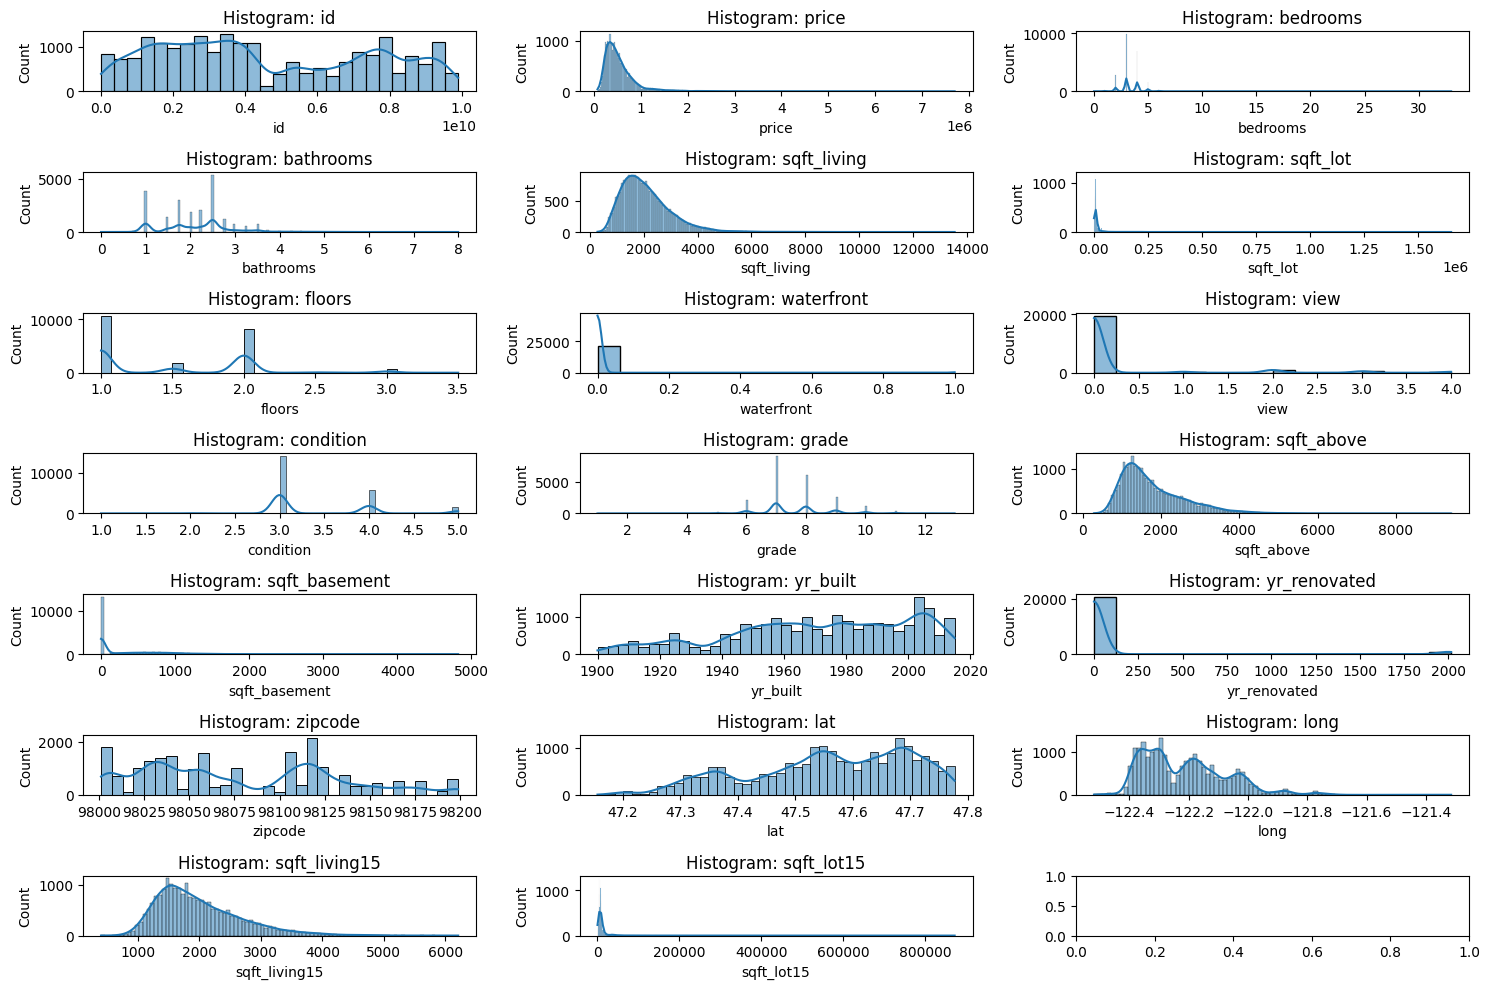

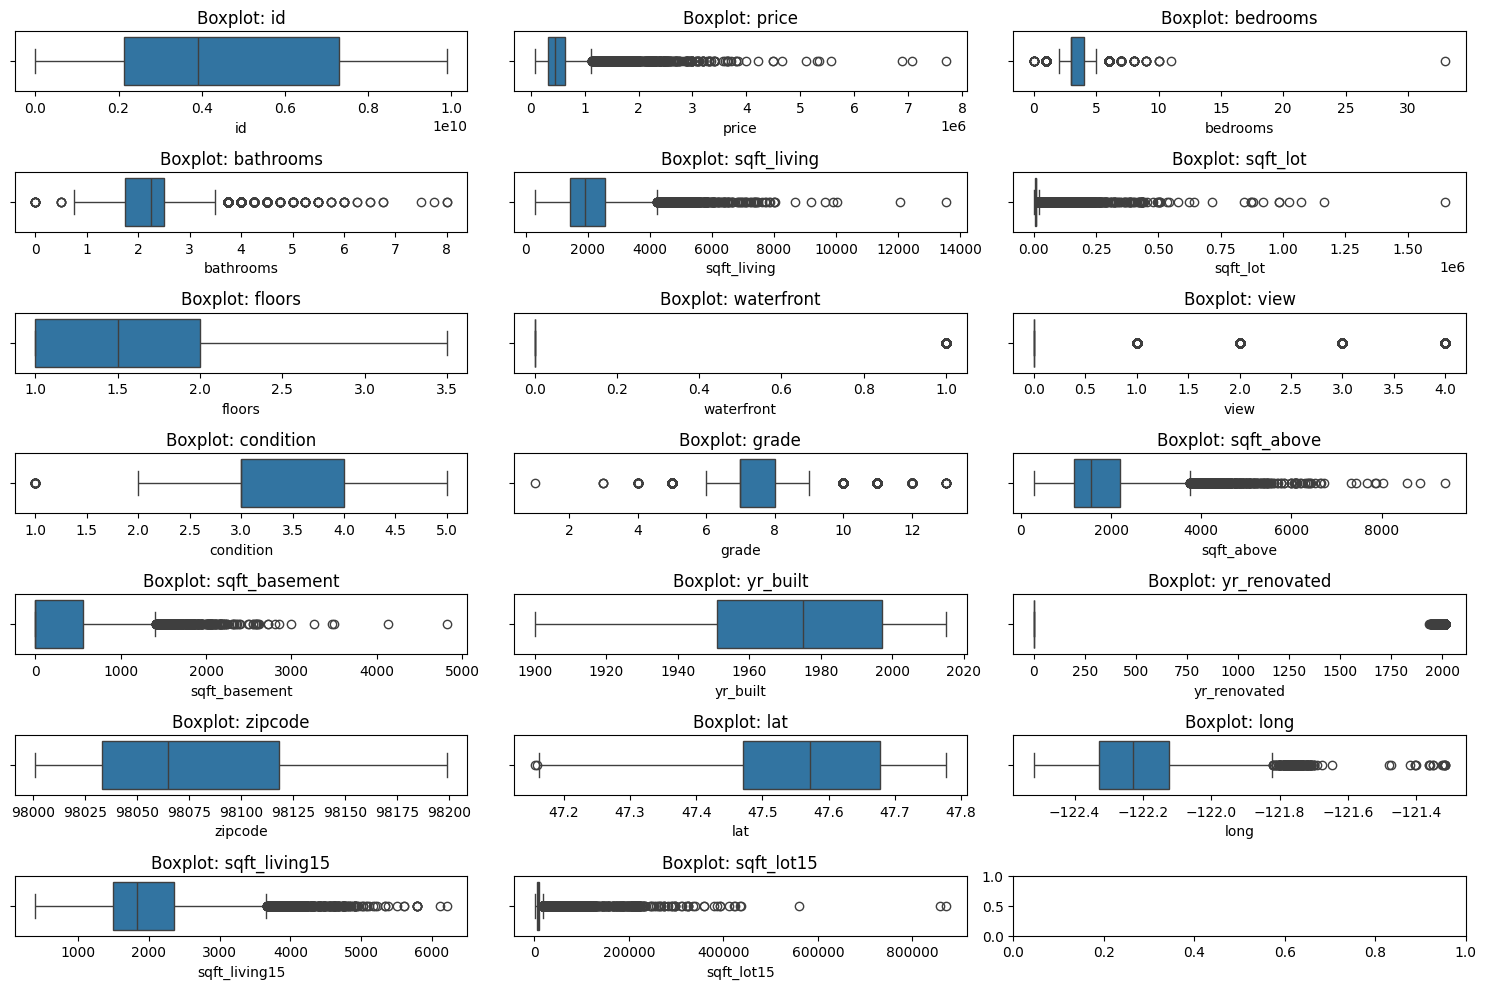

In [68]:
quick_eda(sales)

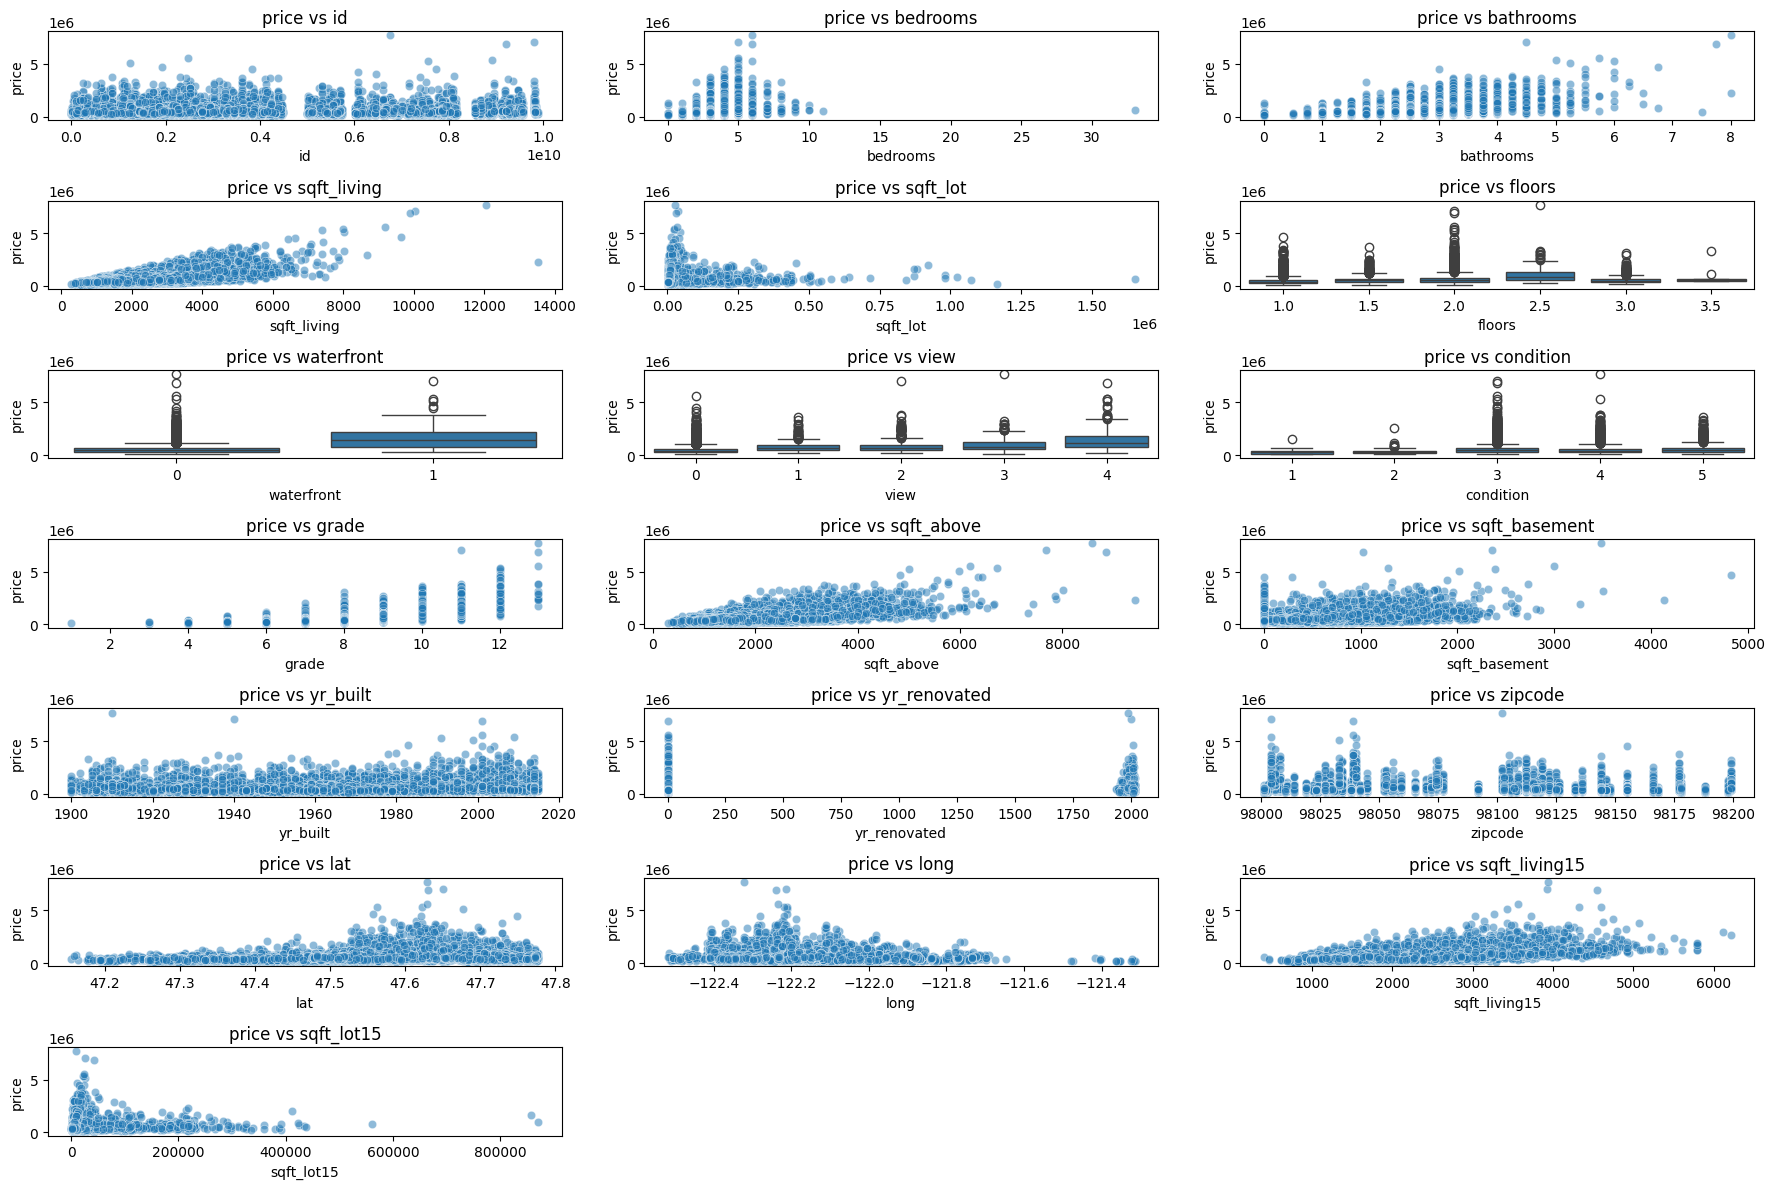

In [69]:
target_relations(sales, 'price')

In [3]:
sales.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [4]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [97]:
sales.describe(percentiles = [0, 0.25, 0.5, 0.75, 0.98, 1])


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
0%,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
98%,9.528103e+09,1.600000e+06,5.000000,3.750000,4410.000000,1.071570e+05,3.000000,0.000000,3.000000,5.000000,11.000000,3970.000000,1450.000000,2014.000000,2000.000000,98198.000000,47.767600,-121.872240,3767.600000,80188.280000
100%,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [6]:
sales[sales.bedrooms > 10]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8757,1773100755,20140821T000000,520000.0,11,3.00,3000,4960,2.0,0,0,...,7,2400,600,1918,1999,98106,47.5560,-122.363,1420,4960
15870,2402100895,20140625T000000,640000.0,33,1.75,1620,6000,1.0,0,0,...,7,1040,580,1947,0,98103,47.6878,-122.331,1330,4700


Значення bedrooms = 33 схоже на викид, для коректної роботи алгоритму це спостереження потрібно видалити.

In [26]:
sales.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

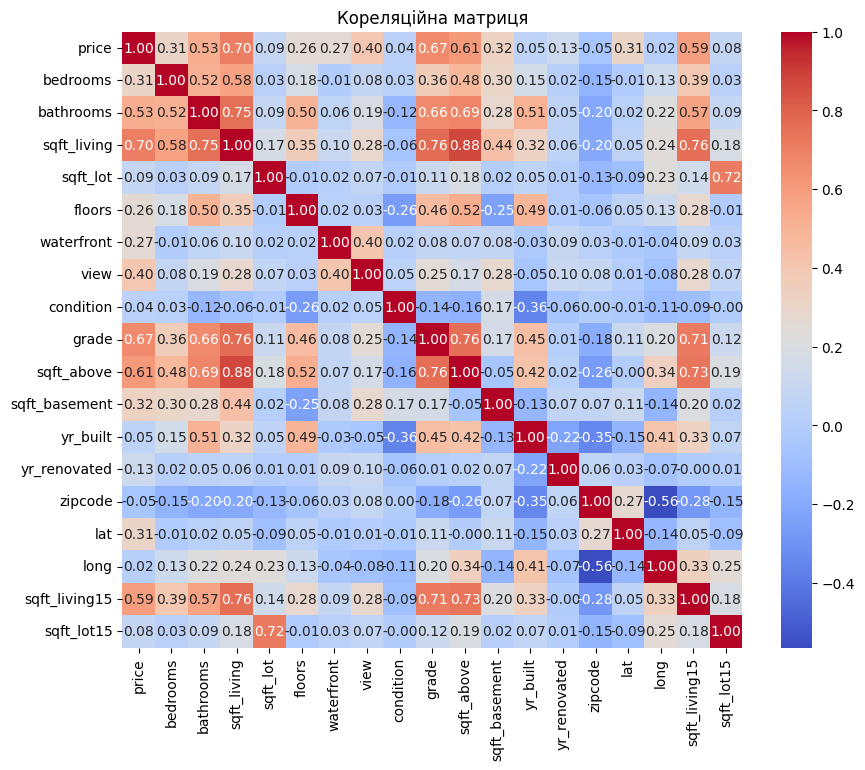

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

columns_for_corr = sales.columns.drop(['id', 'date'])

plt.figure(figsize=(10,8))
corr = sales[columns_for_corr].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Кореляційна матриця")
plt.show()

In [51]:
# Ознаки, які найбільше впливають на зростання цільової змінної
corr.price.drop("price").sort_values(key=lambda x: x.abs(), ascending=False).head(5)

,price
sqft_living,0.702035
grade,0.667434
sqft_above,0.605567
sqft_living15,0.585379
bathrooms,0.525138


In [47]:
from scipy.stats import pearsonr

results = []
for col in columns_for_corr.drop('price'):
  pair = sales[[col, 'price']]
  r, p = pearsonr(pair[col], pair['price'])
  results.append((col, r, p))

pd.DataFrame(results, columns=["feature", "r", "p"]).sort_values("r", key=lambda x: x.abs(), ascending=False).head(10)

,feature,r,p
2,sqft_living,0.702035,0.0
8,grade,0.667434,0.0
9,sqft_above,0.605567,0.0
16,sqft_living15,0.585379,0.0
1,bathrooms,0.525138,0.0
6,view,0.397293,0.0
10,sqft_basement,0.323816,0.0
0,bedrooms,0.308350,0.0
14,lat,0.307003,0.0
5,waterfront,0.266369,0.0


# Split data into training and testing

We use random_state=0 so that everyone running this notebook gets the same results.  In practice, you may set a random seed (or let sklearn pick a random seed for you).  

In [7]:
train_data,test_data = model_selection.train_test_split(sales, test_size = 0.8,random_state=0)

# Useful pandas summary functions

In order to make use of the closed form solution as well as take advantage of numpy's built in functions we will review some important ones. In particular:
* Computing the sum of an DataFrame
* Computing the arithmetic average (mean) of an DataFrame
* multiplying numpy.array by constants
* multiplying numpy.array by other numpy.array's

In [8]:
# Let's compute the mean of the House Prices in King County in 2 different ways.
prices = sales['price'] # extract the price column of the sales DataFrame -- this is now an Series
print('Описова статистика колонки price')
display(prices.describe())
prices = np.array(prices)
# recall that the arithmetic average (the mean) is the sum of the prices divided by the total number of houses:
sum_prices = prices.sum()
num_houses = prices.shape # when prices is an numpy array shape returns its length
print("shape of prices", num_houses)
avg_price_1 = sum_prices/num_houses
avg_price_2 = prices.mean() # if you just want the average, the .mean() function
print("average price via method 1: " + str(avg_price_1))
print("average price via method 2: " + str(avg_price_2))

Описова статистика колонки price


,price
count,2.161300e+04
mean,5.400881e+05
std,3.671272e+05
min,7.500000e+04
25%,3.219500e+05
50%,4.500000e+05
75%,6.450000e+05
max,7.700000e+06


shape of prices (21613,)
average price via method 1: [540088.14176653]
average price via method 2: 540088.1417665294


As we see we get the same answer both ways

In [10]:
# if we want to multiply every price by 0.5 it's a simple as:
half_prices = 0.5*prices

prices_squared = prices*prices
sum_prices_squared = prices_squared.sum()
print("the sum of price squared is: " + str(sum_prices_squared))

the sum of price squared is: 9217325138472070.0


Aside: The python notation x.xxe+yy means x.xx \* 10^(yy). e.g 100 = 10^2 = 1*10^2 = 1e2

# Build a generic simple linear regression function

Armed with these numpy functions we can use the closed form solution found from lecture to compute the slope and intercept for a simple linear regression on observations stored as numpy.array: input_feature, output.

Complete the following function (or write your own) to compute the simple linear regression slope and intercept:

In [11]:
def simple_linear_regression(input_feature, output):

    # compute the sum of input_feature and output
    input_feature_sum = input_feature.sum()
    output_sum = output.sum()

    # compute the product of the output and the input_feature and its sum
    inp_out_poduct = (input_feature * output).sum()

    # compute the squared value of the input_feature and its sum
    input_feature_squar_sum = (input_feature ** 2).sum()

    # use the formula for the slope
    n = len(input_feature)
    slope = (n * inp_out_poduct - input_feature_sum * output_sum) / (n * input_feature_squar_sum - input_feature_sum ** 2)

    # use the formula for the intercept
    intercept = (output_sum - slope * input_feature_sum) / n

    return (intercept, slope)

We can test that our function works by passing it something where we know the answer. In particular we can generate a feature and then put the output exactly on a line: output = 1 + 1\*input_feature then we know both our slope and intercept should be 1

In [12]:
test_feature = np.array(range(5))
test_output = np.array(1 + 1*test_feature)
(test_intercept, test_slope) =  simple_linear_regression(test_feature, test_output)
print("Intercept: " + str(test_intercept))
print("Slope: " + str(test_slope))

Intercept: 1.0
Slope: 1.0


Now that we know it works let's build a regression model for predicting price based on sqft_living. Rembember that we train on train_data!

In [13]:
sqft_intercept, sqft_slope = simple_linear_regression(train_data['sqft_living'], train_data['price'])

print("Intercept: " + str(sqft_intercept))
print("Slope: " + str(sqft_slope))

Intercept: -29748.28678352631
Slope: 273.529912145018


# Predicting Values

Now that we have the model parameters: intercept & slope we can make predictions. Using numpy arrays it's easy to multiply an np.array by a constant and add a constant value. Complete the following function to return the predicted output given the input_feature, slope and intercept:

In [14]:
def get_regression_predictions(input_feature, intercept, slope):
    # calculate the predicted values:
    predicted_values = intercept + slope * input_feature
    return predicted_values

Now that we can calculate a prediction given the slope and intercept let's make a prediction. Use (or alter) the following to find out the estimated price for a house with 2650 squarefeet according to the squarefeet model we estiamted above.

**Quiz Question: Using your Slope and Intercept from (4), What is the predicted price for a house with 2650 sqft?**

In [15]:
my_house_sqft = 2650
estimated_price = get_regression_predictions(my_house_sqft, sqft_intercept, sqft_slope)
print("The estimated price for a house with %d squarefeet is $%.2f" % (my_house_sqft, estimated_price))

The estimated price for a house with 2650 squarefeet is $695105.98


# Residual Sum of Squares

Now that we have a model and can make predictions let's evaluate our model using Residual Sum of Squares (RSS). Recall that RSS is the sum of the squares of the residuals and the residuals is just a fancy word for the difference between the predicted output and the true output.

Complete the following (or write your own) function to compute the RSS of a simple linear regression model given the input_feature, output, intercept and slope:

In [16]:
def get_residual_sum_of_squares(input_feature, output, intercept, slope):

    # First get the predictions
    predictions = intercept + slope * input_feature

    # then compute the residuals (since we are squaring it doesn't matter which order you subtract)
    residuals = predictions - output

    # square the residuals and add them up
    RSS = (residuals ** 2).sum()

    return(RSS)

Let's test our get_residual_sum_of_squares function by applying it to the test model where the data lie exactly on a line. Since they lie exactly on a line the residual sum of squares should be zero!

In [17]:
print(get_residual_sum_of_squares(test_feature, test_output, test_intercept, test_slope)) # should be 0.0

0.0


Now use your function to calculate the RSS on training data from the squarefeet model calculated above.

**Quiz Question: According to this function and the slope and intercept from the squarefeet model What is the RSS for the simple linear regression using squarefeet to predict prices on TRAINING data?**

In [53]:
rss_prices_on_sqft_train = get_residual_sum_of_squares(train_data['sqft_living'], train_data['price'], sqft_intercept, sqft_slope)
print('The RSS of predicting Prices based on Square Feet is : ' + str(rss_prices_on_sqft_train))

The RSS of predicting Prices based on Square Feet is : 273513892228546.28


# Predict the squarefeet given price

What if we want to predict the squarefoot given the price? Since we have an equation y = a + b\*x we can solve the function for x. So that if we have the intercept (a) and the slope (b) and the price (y) we can solve for the estimated squarefeet (x).

Complete the following function to compute the inverse regression estimate, i.e. predict the input_feature given the output.

In [19]:
def inverse_regression_predictions(output, intercept, slope):
    # solve output = intercept + slope*input_feature for input_feature. Use this equation to compute the inverse predictions:
    estimated_feature = (output - intercept)/slope
    return estimated_feature

Now that we have a function to compute the squarefeet given the price from our simple regression model let's see how big we might expect a house that costs $800,000 to be.

**Quiz Question: According to this function and the regression slope and intercept from (3) what is the estimated square-feet for a house costing $800,000?**

In [20]:
my_house_price = 800000
estimated_squarefeet = inverse_regression_predictions(my_house_price, sqft_intercept, sqft_slope)
print("The estimated squarefeet for a house worth $%.2f is %d" % (my_house_price, estimated_squarefeet))

The estimated squarefeet for a house worth $800000.00 is 3033


# New Model: estimate prices from bedrooms

We have made one model for predicting house prices using squarefeet, but there are many other features in the sales DataFrame.
Use your simple linear regression function to estimate the regression parameters from predicting Prices based on number of bedrooms. Use the training data!

In [23]:
# Estimate the slope and intercept for predicting 'price' based on 'bedrooms'

bedrooms_intercept, bedrooms_slope = simple_linear_regression(train_data['bedrooms'], train_data['price'])

print("Intercept:", bedrooms_intercept)
print("Slope:", bedrooms_slope)

Intercept: 195271.72395178716
Slope: 101863.94016117182


# Test your Linear Regression Algorithm

Now we have two models for predicting the price of a house. How do we know which one is better? Calculate the RSS on the TEST data (remember this data wasn't involved in learning the model). Compute the RSS from predicting prices using bedrooms and from predicting prices using squarefeet.

**Quiz Question: Which model (square feet or bedrooms) has lowest RSS on TEST data? Think about why this might be the case.**

In [88]:
# Compute RSS when using bedrooms on TEST data:
rss_prices_on_sqft_test = get_residual_sum_of_squares(test_data['sqft_living'], test_data['price'], sqft_intercept, sqft_slope)
print(f'The RSS of predicting Prices based on Square Feet are: \n train: {rss_prices_on_sqft_train} \n  test: {rss_prices_on_sqft_test}')
print(f'  test = train * {round(rss_prices_on_sqft_test/rss_prices_on_sqft_train, 3)}')

The RSS of predicting Prices based on Square Feet are: 
 train: 273513892228546.28 
  test: 1204698183835745.5
  test = train * 4.405


In [89]:
# Compute RSS when using squarefeet on TEST data:
rss_prices_on_bedrooms_train = get_residual_sum_of_squares(train_data['bedrooms'], train_data['price'], bedrooms_intercept, bedrooms_slope)
rss_prices_on_bedrooms_test = get_residual_sum_of_squares(test_data['bedrooms'], test_data['price'], bedrooms_intercept, bedrooms_slope)
print(f'The RSS of predicting Prices based on bedrooms are: \n train: {rss_prices_on_bedrooms_train} \n  test: {rss_prices_on_bedrooms_test}')
print(f'  test = train * {round(rss_prices_on_bedrooms_test/rss_prices_on_bedrooms_train, 3)}')

The RSS of predicting Prices based on bedrooms are: 
 train: 492988346426067.9 
  test: 2150382968642653.0
  test = train * 4.362


In [92]:
rss_prices_on_sqft_test / rss_prices_on_bedrooms_test

np.float64(0.5602249466271421)

In [79]:
def plot_regression_line(x, y, intercept, slope):# дані
  # x = train_data['bedrooms']
  # y = train_data['price']

  # обчислимо значення прогнозів за формулою прямої y = a + b*x
  y_pred = intercept + slope * x

  # побудова графіка
  plt.figure(figsize=(8,6))
  plt.scatter(x, y, color='blue', alpha=0.5, label='Дані (спостереження)')
  plt.plot(np.sort(x), intercept + slope * np.sort(x),
          color='red', linewidth=2, label='Лінія регресії')

  plt.xlabel('Кількість спалень (bedrooms)')
  plt.ylabel('Ціна (price)')
  plt.title('Лінійна залежність між кількістю спалень і ціною')
  plt.legend()
  plt.grid(True)
  plt.show()

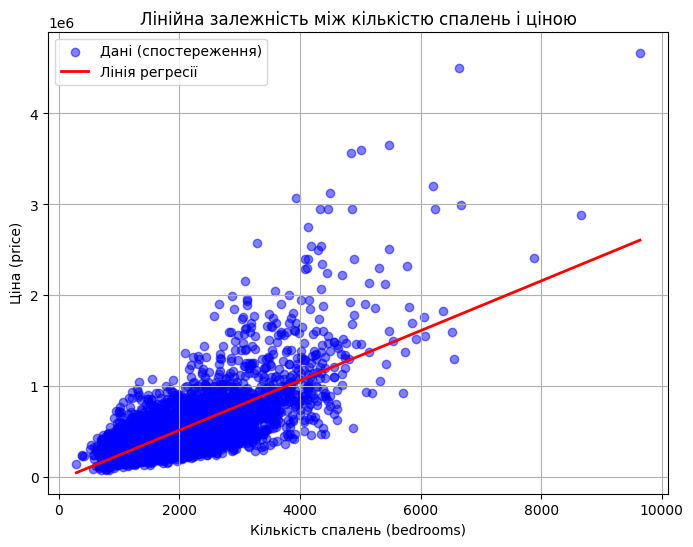

In [81]:
plot_regression_line(train_data['sqft_living'], train_data['price'], sqft_intercept, sqft_slope)

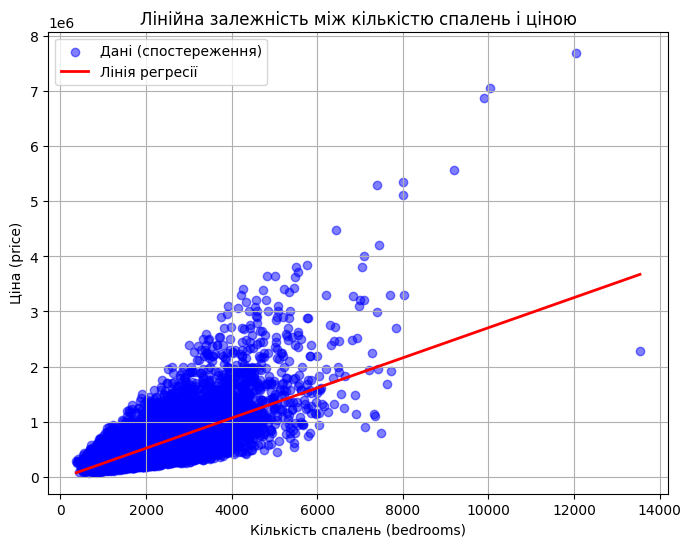

In [82]:
plot_regression_line(test_data['sqft_living'], test_data['price'], sqft_intercept, sqft_slope)

In [84]:
grade_intercept, grade_slope = simple_linear_regression(train_data['grade'], train_data['price'])

print("Intercept:", grade_intercept)
print("Slope:", grade_slope)

Intercept: -1010556.4121510074
Slope: 202357.7147143919


In [85]:
rss_prices_on_grade_train = get_residual_sum_of_squares(train_data['grade'], train_data['price'], grade_intercept, grade_slope)
rss_prices_on_grade_test = get_residual_sum_of_squares(test_data['grade'], test_data['price'], grade_intercept, grade_slope)
print(f'The RSS of predicting Prices based on grade are: \n train: {rss_prices_on_grade_train} \n  test: {rss_prices_on_grade_test}')
print(f'  test = train * {round(rss_prices_on_grade_test/rss_prices_on_grade_train, 1)}')

The RSS of predicting Prices based on grade are: 
 train: 301319438358653.06 
  test: 1315127810706420.5
  test = train * 4.4


In [86]:
301319438358653.06 /1315127810706420.5

0.22911798830928792

In [87]:
1315127810706420.5/301319438358653.06

4.364563460857963

In [93]:
sales_cleaned = sales[sales.bedrooms <15]

In [96]:
sales_cleaned.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161200e+04,2.161200e+04,21612.000000,21612.000000,21612.000000,2.161200e+04,21612.000000,21612.000000,21612.000000,21612.000000,21612.000000,21612.000000,21612.000000,21612.000000,21612.000000,21612.000000,21612.000000,21612.000000,21612.000000,21612.000000
mean,4.580402e+09,5.400835e+05,3.369471,2.114774,2079.921016,1.510739e+04,1.494332,0.007542,0.234314,3.409356,7.656904,1788.425319,291.495697,1971.006247,84.406163,98077.938645,47.560047,-122.213891,1986.582871,12768.828984
std,2.876594e+09,3.671351e+05,0.907982,0.770177,918.456818,4.142142e+04,0.539991,0.086519,0.766334,0.650668,1.175477,828.094487,442.580931,29.373636,401.688123,53.505993,0.138564,0.140829,685.392610,27304.756179
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.218375e+05,3.000000,1.750000,1426.500000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.470975,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.619000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068825e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.250000
max,9.900000e+09,7.700000e+06,11.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000
